# Grubbs’ 检验

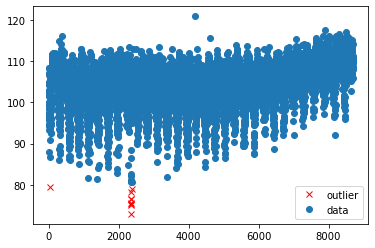

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as tdist
import pandas as pd

def grubbs_test(data, alpha):
    """
    对数据进行Grubbs'检验，返回是否存在离群点

    参数：
    data -- 需要检验的数据，numpy数组或列表
    alpha -- 显著性水平，一般取0.05

    返回：
    是否存在离群点，True或False
    """

    # 计算样本均值、标准差和样本大小
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)

    # 计算t分布临界值
    tval = tdist.ppf(1-alpha/(2*n), n-2)

    # 计算Grubbs'统计量和临界值
    G = np.max(np.abs(data-mean))/std
    Gcrit = (n-1)/np.sqrt(n)*np.sqrt(tval**2/(n-2+tval**2))

    # 判断是否存在离群点
    if G > Gcrit:
        return True
    else:
        return False

#导入数据
df = pd.read_csv('Traffic_flow.csv',delimiter=',',header=None)
df.columns = ['位置','时间','流量','速度','占有率','方向']
df = df[df['方向']==0]
data = df['速度'].values

# 对数据进行Grubbs'检验
alpha = 0.05
is_outlier = grubbs_test(data, alpha)

# 如果存在离群点，则标出离群点
if is_outlier:
    Gcrit = (len(data)-1)/np.sqrt(len(data))*np.sqrt(tdist.ppf(1-alpha/(2*len(data)), len(data)-2)**2/(len(data)-2+tdist.ppf(1-alpha/(2*len(data)), len(data)-2)**2))
    outliers = np.where(np.abs(data - np.mean(data)) > np.std(data) * Gcrit)[0]
    plt.plot(outliers, data[outliers], 'rx', label='outlier')
    
normal_data = np.delete(data, outliers)

# 绘制数据集
plt.plot(normal_data, 'o', label='data')

plt.legend()
plt.show()

# 基于似然的离群点检测

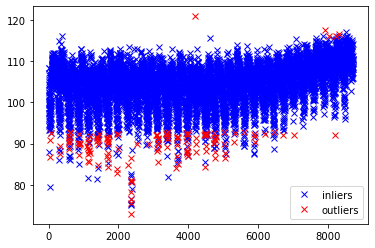

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

def log_likelihood(data, mu, sigma):
    return np.sum(np.log(norm.pdf(data, mu, sigma)))

def detect_outliers(data, alpha=0.05, threshold=5):
    mu = np.mean(data)
    sigma = np.std(data)
    M = np.arange(len(data))
    A = np.array([], dtype=int)
    Lt = log_likelihood(data, mu, sigma)
    L = [Lt]

    for i in range(len(M)):
        if i >= len(M):
            break
        x = M[i]
        M_new = np.delete(M, np.where(M == x))
        Lt1 = log_likelihood(data[M_new], mu, sigma)
        delta = abs(Lt - Lt1)

        if delta > threshold:
            A = np.append(A, x)
            M = M_new
            Lt = Lt1
        else:
            M = np.append(M_new, x)

        L.append(Lt1)

    A = A.astype(int)
    M = M.astype(int)

    return A, M, L

#导入数据
df = pd.read_csv('Traffic_flow.csv',delimiter=',',header=None)
df.columns = ['位置','时间','流量','速度','占有率','方向']
df = df[df['方向']==0]
data = df['速度'].values

# 检测离群点
A, M, L = detect_outliers(data)

# 可视化
plt.plot(M, data[M], 'bx', label='inliers')
plt.plot(A, data[A], 'rx', label='outliers')
plt.legend()
plt.show()

# 基于邻近度的离群点检测

[[ 82.23100281 195.        ]
 [105.1019974  187.        ]
 [ 81.06199646 113.        ]
 [ 78.94400024 125.        ]
 [ 82.73200226 183.        ]
 [ 80.84600067 182.        ]
 [108.1669998  180.        ]
 [ 80.76100159 134.        ]
 [ 75.38600159 166.        ]
 [ 86.63500214 156.        ]]


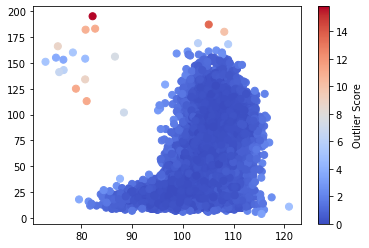

In [109]:
from sklearn.neighbors import BallTree
import numpy as np

#导入数据
df = pd.read_csv('Traffic_flow.csv',delimiter=',',header=None)
df.columns = ['位置','时间','流量','速度','占有率','方向']
df = df[df['方向']==0]
data = df[['速度','流量']].values

# 构建BallTree
tree = BallTree(data)

# 计算每个数据点到其5个最近邻的距离
distances, indices = tree.query(data, k=5)

# 对每个数据点的距离求平均，得到离群点得分
outlier_scores = np.mean(distances, axis=1)

# 根据离群点得分进行排序，得到离群点索引
outlier_indices = np.argsort(outlier_scores)[::-1]

# 输出前10个离群点
print(data[outlier_indices[:10]])

# 绘制散点图
plt.scatter(data[:, 0], data[:, 1],s=50, c=outlier_scores, cmap='coolwarm')

# 添加colorbar
cb = plt.colorbar()
cb.set_label('Outlier Score')
plt.show()

# 基于密度的离群点检测方法:LOF方法

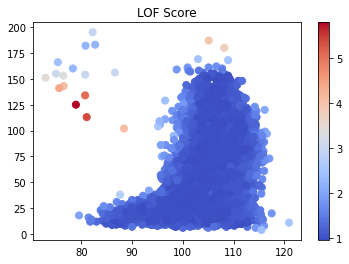

In [110]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor

#导入数据
df = pd.read_csv('Traffic_flow.csv',delimiter=',',header=None)
df.columns = ['位置','时间','流量','速度','占有率','方向']
df = df[df['方向']==0]
data = df[['速度','流量']].values

# 使用LOF算法进行异常点检测
clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
y_pred = clf.fit_predict(data)
lof_score = -clf.negative_outlier_factor_

# 可视化结果
plt.title("Local Outlier Factor (LOF)")
plt.scatter(data[:, 0], data[:, 1],s=50, c=lof_score, cmap='coolwarm')
plt.colorbar()
plt.title("LOF Score")
plt.show()

# 基于聚类的离群点检测方法

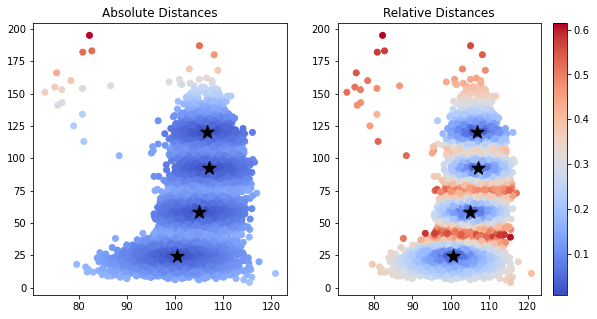

In [153]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

#导入数据
df = pd.read_csv('Traffic_flow.csv',delimiter=',',header=None)
df.columns = ['位置','时间','流量','速度','占有率','方向']
df = df[df['方向']==0]
data = df[['速度','流量']].values

# 构建KMeans模型，聚类中心数为4
kmeans = KMeans(n_clusters=4)

# 训练模型并预测簇标签
y_pred = kmeans.fit_predict(data)

# 获取聚类中心坐标
centers = kmeans.cluster_centers_

# 计算每个点到其最近聚类中心的绝对距离
distances = [np.linalg.norm(x - centers[y_pred[i]]) for i, x in enumerate(data)]

# 计算每个点到所有点的中位距离
median_distances = []
for i, x in enumerate(data):
    distances_i = [np.linalg.norm(x - x_j) for j, x_j in enumerate(data)]
    median_distances.append(np.median(distances_i))

# 计算每个点到最近聚类中心的相对距离
relative_distances = [distances[i] / median_distances[i] for i in range(len(data))]

# 绘制散点图
plt.figure(figsize=(10, 5))

# 绘制绝对距离散点图
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c=distances, cmap='coolwarm')
plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=200, c='black')
plt.title('Absolute Distances')

# 绘制相对距离散点图
plt.subplot(1, 2, 2)
plt.scatter(data[:, 0], data[:, 1], c=relative_distances, cmap='coolwarm')
plt.colorbar()
plt.scatter(centers[:, 0], centers[:, 1], marker='*', s=200, c='black')
plt.title('Relative Distances')
plt.show()

# 基于重构的离群点检测（PCA）

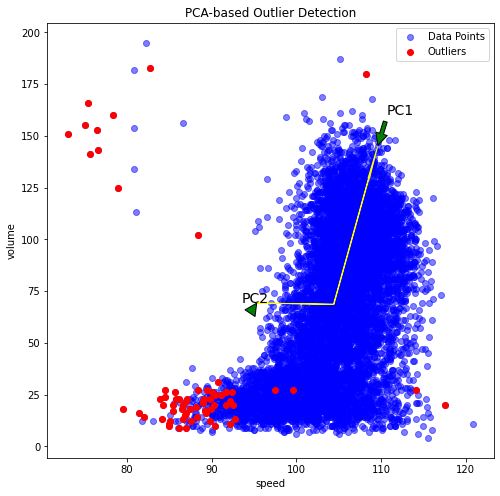

In [150]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#导入数据
df = pd.read_csv('Traffic_flow.csv',delimiter=',',header=None)
df.columns = ['位置','时间','流量','速度','占有率','方向']
df = df[df['方向']==0]
data = df[['速度','流量']].values

# PCA变换
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

# 计算重构误差
X_recon = pca.inverse_transform(X_pca)
dist = np.abs(data - X_recon)
dist = np.sum(dist, axis=1)

# 选取离群点
threshold = np.percentile(dist, 98)
outliers = data[dist > threshold]

# 可视化数据与离群点
plt.figure(figsize=(8, 8))
plt.scatter(data[:, 0], data[:, 1], color='b', alpha=0.5, label='Data Points')
plt.scatter(outliers[:, 0], outliers[:, 1], color='r', label='Outliers')

# 添加PCA轴方向
scale_x = np.sqrt(pca.explained_variance_[0]) * 2
scale_y = np.sqrt(pca.explained_variance_[1]) * 2
arrow1 = plt.Arrow(pca.mean_[0], pca.mean_[1], pca.components_[0][0]*scale_x, pca.components_[0][1]*scale_x, color='yellow', width=0.3)
arrow2 = plt.Arrow(pca.mean_[0], pca.mean_[1], pca.components_[1][0]*scale_y, pca.components_[1][1]*scale_y, color='yellow', width=0.3)
plt.gca().add_patch(arrow1)
plt.gca().add_patch(arrow2)
plt.annotate('PC1', xy=(pca.mean_[0]+pca.components_[0][0]*scale_x, pca.mean_[1]+pca.components_[0][1]*scale_x), xytext=(pca.mean_[0]+pca.components_[0][0]*scale_x*1.2, pca.mean_[1]+pca.components_[0][1]*scale_x*1.2), fontsize=14, arrowprops=dict(facecolor='green', shrink=0.05))
plt.annotate('PC2', xy=(pca.mean_[0]+pca.components_[1][0]*scale_y, pca.mean_[1]+pca.components_[1][1]*scale_y), xytext=(pca.mean_[0]+pca.components_[1][0]*scale_y*1.2, pca.mean_[1]+pca.components_[1][1]*scale_y*1.2), fontsize=14, arrowprops=dict(facecolor='green', shrink=0.05))


plt.xlabel('speed')
plt.ylabel('volume')
plt.title('PCA-based Outlier Detection')
plt.legend()
plt.show()


# 基于重构的离群点检测（autoencoder）

Epoch 1/50
218/218 [==============================] - 0s 629us/step - loss: 8336.7539 - val_loss: 8497.3643
Epoch 2/50
218/218 [==============================] - 0s 357us/step - loss: 8336.7549 - val_loss: 8497.3643
Epoch 3/50
218/218 [==============================] - 0s 348us/step - loss: 8336.7578 - val_loss: 8497.3643
Epoch 4/50
218/218 [==============================] - 0s 352us/step - loss: 8336.7568 - val_loss: 8497.3643
Epoch 5/50
218/218 [==============================] - 0s 339us/step - loss: 8336.7529 - val_loss: 8497.3643
Epoch 6/50
218/218 [==============================] - 0s 384us/step - loss: 8336.7578 - val_loss: 8497.3643
Epoch 7/50
218/218 [==============================] - 0s 361us/step - loss: 8336.7539 - val_loss: 8497.3643
Epoch 8/50
218/218 [==============================] - 0s 366us/step - loss: 8336.7568 - val_loss: 8497.3643
Epoch 9/50
218/218 [==============================] - 0s 339us/step - loss: 8336.7559 - val_loss: 8497.3643
Epoch 10/50
218/218 [=======

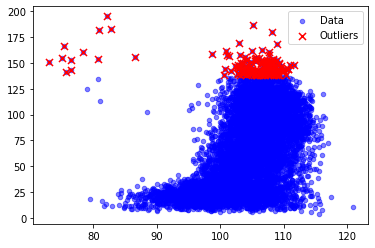

In [172]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

#导入数据
df = pd.read_csv('Traffic_flow.csv',delimiter=',',header=None)
df.columns = ['位置','时间','流量','速度','占有率','方向']
df = df[df['方向']==0]
data = df[['速度','流量']].values

# 构建Autoencoder模型
input_dim = data.shape[1]
encoding_dim = 5
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation='relu')(input_layer)
decoder = Dense(input_dim, activation='sigmoid')(encoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# 编译并训练模型
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(data, data, epochs=50, batch_size=32, shuffle=True, validation_split=0.2)

# 对所有数据进行重构并计算重构误差
reconstructed = autoencoder.predict(data)
reconstruction_error = np.abs(data - reconstructed)

# 选取重构误差大的点为离群点
threshold = np.percentile(reconstruction_error, 99)
outliers = np.where(reconstruction_error > threshold)[0]

# 可视化数据与离群点
plt.scatter(data[:, 0], data[:, 1], s=20, c='b', alpha=0.5, label='Data')
plt.scatter(data[outliers, 0], data[outliers, 1], s=50, c='r', marker='x', label='Outliers')
plt.legend()
plt.show()

# 基于单类分类的离群点检测方法—单类SVM

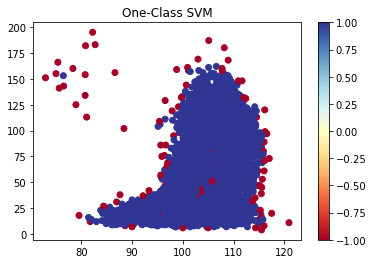

In [184]:
from sklearn.svm import OneClassSVM
import numpy as np
import matplotlib.pyplot as plt

#导入数据
df = pd.read_csv('Traffic_flow.csv',delimiter=',',header=None)
df.columns = ['位置','时间','流量','速度','占有率','方向']
df = df[df['方向']==0]
data = df[['速度','流量']].values

# 训练单类 SVM
clf = OneClassSVM(nu=0.01, kernel='rbf', gamma=0.01)
clf.fit(data)

# 预测并可视化结果
y_pred = clf.predict(data)
plt.scatter(data[:, 0], data[:, 1], c=y_pred, cmap='RdYlBu')
plt.colorbar()
plt.title('One-Class SVM')
plt.show()


# 基于信息论的离群点检测

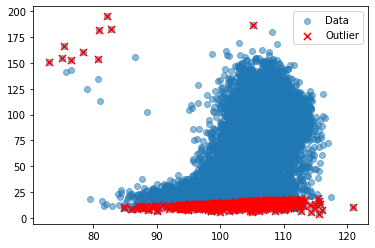

In [241]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import entropy


#导入数据
df = pd.read_csv('Traffic_flow.csv',delimiter=',',header=None)
df.columns = ['位置','时间','流量','速度','占有率','方向']
df = df[df['方向']==0]
data = df[['速度','流量']].values


def info_gain(X, idx):
    
    # 计算熵值
    joint_entropy_before = entropy(X[:, 0], X[:, 1])
    
    # 删除该点后的样本
    X_new = np.delete(X, idx, axis=0)
    joint_entropy_after = entropy(X_new[:, 0], X_new[:, 1])
    
    # 计算信息增益
    info_gain = joint_entropy_before - joint_entropy_after
    
    return info_gain

# 计算每个点的信息增益
info_gains = []
for i in range(data.shape[0]):
    info_gains.append(info_gain(data, i))

# 找到信息增益最大的点作为异常点
n = len(data)
sorted_indices = np.argsort(info_gains)[::-1]  # 从大到小排序
n_outliers = int(0.05 * n)
outlier_indices = sorted_indices[:n_outliers]

# 可视化结果
plt.scatter(data[:, 0], data[:, 1], alpha=0.5, label='Data')
plt.scatter(data[outlier_indices, 0], data[outlier_indices, 1], c='r', marker='x', s=50, label='Outlier')
plt.legend()
plt.show()